#Severe Weather Forecasting with Python and Data Science Tools: Interactive Demo
David John Gagne


##Introduction
Severe weather forecasting has entered an age of unprecedented access to large model and observational datasets with even greater hordes of data in the pipeline. With multiple ensembles of convection-allowing models available and an increasing variety of observations derived from radar, satellite, surface, upper air, and crowd-sourcing, forecasters can easily be overwhelmed with guidance. Without ways to organize, synthesize, and visualize the data in a useful manner for forecasters, the pile of new models and observations will languish unused and will not fulfill their full potential. An even worse outcome would be to take the human forecasters completely out of the loop and trust the models, which is a way fraught with peril. Data science tools offer ways to synthesize essential information from many disparate data sources while also quantifying uncertainty. When forecasters use the tools properly, they can identify potential hazards and the associated spatial and time uncertainties more quickly by using the output of the tools to help target their domain knowledge. 

This module demonstrates how data science tools from the image processing and machine learning families can be used to create a forecast of severe hail. It aims to teach the advantages, challenges, and limitations of these tools through hands-on interaction. 

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display
from IPython.html import widgets
from scipy.ndimage import gaussian_filter, find_objects
from copy import deepcopy
from glob import glob

### Part 1: Storm Track Identification
We will be using the hagelslag library to perform object-based data processing of convection-allowing model output. 

In [54]:
from hagelslag.processing.EnhancedWatershedSegmenter import EnhancedWatershed
from hagelslag.data.ModelOutput import ModelOutput
from hagelslag.processing.ObjectMatcher import ObjectMatcher, shifted_centroid_distance, centroid_distance
from hagelslag.processing.STObject import STObject

We will be using model output from the control run of the Center for Analysis and Prediction of Storms 2015 Storm-Scale Ensemble Forecast system. The model output tar file can be downloaded from the Unidata RAMADDA server or from http://www.caps.ou.edu/~djgagne/spring2015_unidata.tar.gz. Please untar the data in a local directory and modify the `model_path` variable below to point to the spring2015_unidata directory.

In [3]:
# modify model_path for your local system.
model_path = "/Users/djgagne/research/spring2015_unidata/"
ensemble_name = "SSEF"
member ="wrf-s3cn_arw"
run_date = datetime(2015, 6, 4)
# We will be using the uh_max (hourly max 2-5 km Updraft Helicity) variable for this exercise
# cmpref (simulated composite radar reflectivity) is also available.
variable = "uh_max"
start_date = run_date + timedelta(hours=12)
end_date = run_date + timedelta(hours=29)
model_grid = ModelOutput(ensemble_name, 
                         member, 
                         run_date, 
                         variable, 
                         start_date, 
                         end_date,
                         model_path,
                         single_step=False)
model_grid.load_data()
model_grid.load_map_info("../mapfiles/ssef2015.map")

Loading SSEF


The max updraft helicity map over the full period shows mutiple long and intense tracks in the central Plains. 

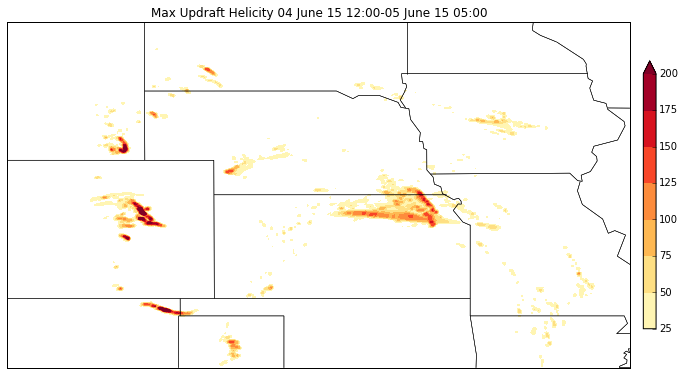

In [10]:
lon_range = (-108, -90)
lat_range = (35, 45)
basemap = Basemap(projection="cyl", 
                  resolution="l",
                  llcrnrlon=lon_range[0], 
                  urcrnrlon=lon_range[1],
                  llcrnrlat=lat_range[0],
                  urcrnrlat=lat_range[1])
plt.figure(figsize=(12,8))
basemap.drawstates()
plt.contourf(model_grid.lon, 
             model_grid.lat, 
             model_grid.data.max(axis=0), 
             np.arange(25,225,25), 
             extend="max",
             cmap="YlOrRd")
plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02 )
title_info = plt.title("Max Updraft Helicity {0}-{1}".format(start_date.strftime("%d %B %y %H:%M"), 
                                                             end_date.strftime("%d %B %y %H:%M")))

To investigate the timing of the tracks, we can use this interactive widget to explore the tracks through time and to zoom in on areas of interest.

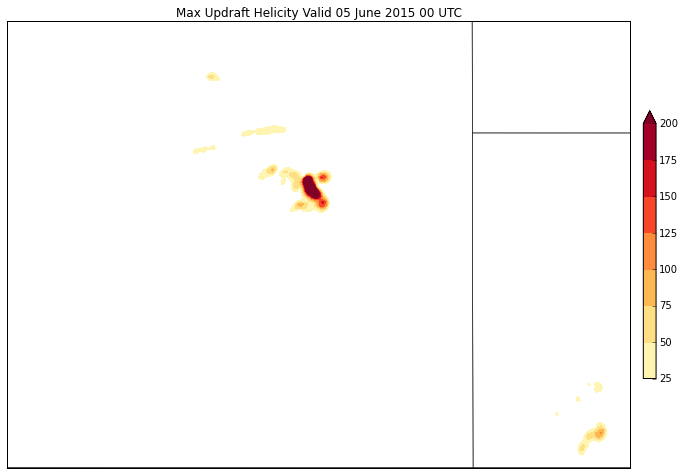

In [28]:
zoomable_bmap = Basemap(projection="cyl", 
                        resolution="l", 
                        llcrnrlon=model_grid.lon.min(),
                        llcrnrlat=model_grid.lat.min(),
                        urcrnrlon=model_grid.lon.max(),
                        urcrnrlat=model_grid.lat.max(),
                        fix_aspect=False)
def model_time_viewer(lon_range, lat_range, hour):
    #lon_range = (-108, -90)
    #lat_range = (35, 45)
    #basemap = Basemap(projection="cyl", 
    #                  resolution="l",
    #                  llcrnrlon=lon_range[0], 
    #                  urcrnrlon=lon_range[1],
    #                  llcrnrlat=lat_range[0],
    #                  urcrnrlat=lat_range[1])
    plt.figure(figsize=(12,8))
    zoomable_bmap.drawstates()
    zoomable_bmap.drawcoastlines()
    zoomable_bmap.drawcountries()
    plt.contourf(model_grid.lon, 
                 model_grid.lat, 
                 model_grid.data[hour - model_grid.start_hour], 
                 np.arange(25,225,25), 
                 extend="max",
                 cmap="YlOrRd")
    plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02)
    title_info = plt.title("Max Updraft Helicity Valid {0}".format((run_date + timedelta(hours=hour)).strftime(
                "%d %B %Y %H UTC")))
    plt.xlim(*lon_range)
    plt.ylim(*lat_range)
lon_slider = widgets.IntRangeSlider(min=int(model_grid.lon.min()), 
                                    max=int(model_grid.lon.max()), 
                                    step=1, value=(-108, -90))
lat_slider = widgets.IntRangeSlider(min=int(model_grid.lat.min()), 
                                    max=int(model_grid.lat.max()), 
                                    value=(35,45),
                                    step=1)
hour_slider = widgets.IntSlider(min=model_grid.start_hour, max=model_grid.end_hour, step=1, value=0)
w = widgets.interactive(model_time_viewer, lon_range=lon_slider, lat_range=lat_slider, hour=hour_slider)
display(w)

###Storm Track Identification with the Enhanced Watershed
Our first data science tool is the enhanced watershed (Lakshmanan 2009), which is used for identifying features in gridded data. The original watershed transform identifies regions from an image or grid by finding local maxima and then growing objects from those maxima in discrete steps by looking for adjacent pixels with at least a certain intensity in an iterative fashion. The traditional watershed uses an intensity threshold as the stopping criterion for growth, which can produce unrealistic looking objects. The enhanced watershed first discretizes the data and then uses size and relative intensity thresholds to identify discrete objects. Buffer regions are also created around each object.

The enhanced watershed has the following tunable parameters:
* min, step, max: parameters to quantize the grid into a discrete number of levels
* size: growth of an object is stopped after it reaches the specified number of grid points in area
* delta: the maximum range of values contained within an object

#####Exercise: Manual Tuning
Pick a model time step and tune the enhanced watershed parameters until the objects look reasonable. Note how changing parameter values affects the shape of the objects. See how your chosen set of parameters handles other time steps. Finally, see what parameter settings produce particularly poor objects. If you find either a particularly good representation or a hilariously bad one, right-click the image, save it, and email the image to me at djgagne@ou.edu.

Reference:  Valliappa Lakshmanan, Kurt Hondl, and Robert Rabin, 2009: An Efficient, General-Purpose Technique for Identifying Storm Cells in Geospatial Images. J. Atmos. Oceanic Technol., 26, 523–537.
doi: http://dx.doi.org/10.1175/2008JTECHA1153.1 

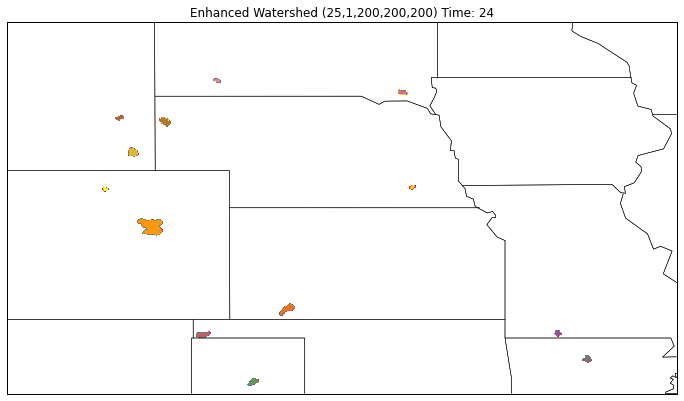

In [32]:
def ew_demo(min_max, step_val, size_val=50, delta_val=5, time=12):
    ew = EnhancedWatershed(min_max[0],step_val,min_max[1],size_val,delta_val)
    plt.figure(figsize=(12,8))
    basemap.drawstates()
    labels = ew.label(gaussian_filter(model_grid.data[time - model_grid.start_hour], 1))
    plt.contourf(model_grid.lon, 
                 model_grid.lat, 
                 labels, 
                 np.arange(1,labels.max()), 
                 extend="max",
                 cmap="Set1")
    plt.xlim(*lon_range)
    plt.ylim(*lat_range)
    plt.grid()
    plt.title("Enhanced Watershed ({0:d},{1:d},{2:d},{3:d},{4:d}) Time: {5:d}".format(min_max[0], 
                                                                                      step_val, 
                                                                                      min_max[1], 
                                                                                      size_val, 
                                                                                      delta_val, 
                                                                                      time))
minmax_slider = widgets.IntRangeSlider(min=10, max=300, step=10, value=(25,200))
step_slider = widgets.IntSlider(min=1, max=10, step=1, value=1)
size_slider = widgets.IntSlider(min=5, max=200, step=5, value=50)
delta_slider = widgets.IntSlider(min=10, max=200, step=10, value=20)
time_slider = widgets.IntSlider(min=model_grid.start_hour, max=model_grid.end_hour, step=1, value=24)
w = widgets.interactive(ew_demo, 
                        min_max=minmax_slider,          
                        step_val=step_slider, 
                        size_val=size_slider, 
                        delta_val=delta_slider,
                        time=time_slider)
display(w)

Once you find a desirable set of enhanced watershed parameters, input them below and generate storm objects for all time steps.

In [68]:
def get_forecast_objects(model_grid, ew_params, min_size, gaussian_window):
    ew = EnhancedWatershed(*ew_params)
    model_objects = []
    print "Find model objects Hour:",
    for h, hour in enumerate(np.arange(model_grid.start_hour, model_grid.end_hour + 1)):
        print "{0:02d}".format(hour),
        hour_labels = ew.size_filter(ew.label(gaussian_filter(model_grid.data[h], gaussian_window)), min_size)
        obj_slices = find_objects(hour_labels)
        num_slices = len(obj_slices)
        model_objects.append([])
        if num_slices > 0:
            for sl in obj_slices:   
                model_objects[-1].append(STObject(model_grid.data[h][sl],
                                                  np.where(hour_labels[sl] > 0, 1, 0),
                                                  model_grid.x[sl], 
                                                  model_grid.y[sl], 
                                                  model_grid.i[sl], 
                                                  model_grid.j[sl],
                                                  hour,
                                                  hour,
                                                  dx=3000))
                if h > 0:
                    dims = model_objects[-1][-1].timesteps[0].shape
                    model_objects[-1][-1].estimate_motion(hour, model_grid.data[h-1], dims[1], dims[0])
    return model_objects

min_thresh = 20
max_thresh = 200
step = 1
max_size = 90
min_size = 20
delta = 100
gaussian_filter_size = 2

model_objects = get_forecast_objects(model_grid, (min_thresh, step, max_thresh, max_size, delta), 
                                     min_size, gaussian_filter_size)

Find model objects Hour: 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29


###Object Tracking
Tracking storms over time provides useful information about their evolution and threat potential. However, storm tracking is a challenging problem due to storms forming, splitting, merging, and dying. Basic object-based storm tracking methods compare the locations of storms at one time step with the locations at the previous time steps and then find an optimal way to match storms from the two sets appropriately. 

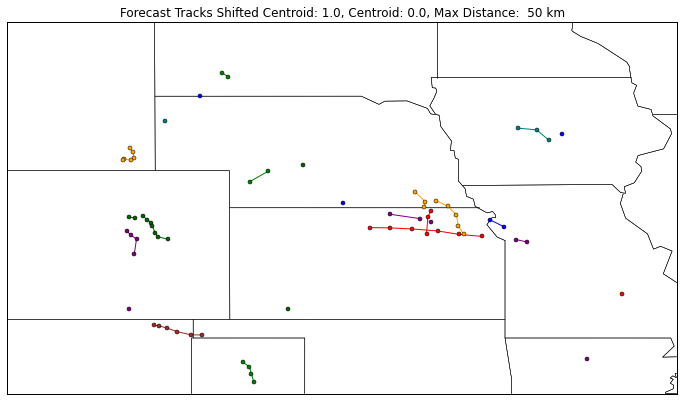

In [71]:
def track_forecast_objects(input_model_objects, model_grid, object_matcher):
    model_objects = deepcopy(input_model_objects)
    hours = np.arange(int(model_grid.start_hour), int(model_grid.end_hour) + 1)
    tracked_model_objects = []
    for h, hour in enumerate(hours):
        past_time_objs = []
        for obj in tracked_model_objects:
            # Potential trackable objects are identified
            if obj.end_time == hour - 1:
                past_time_objs.append(obj)
        # If no objects existed in the last time step, then consider objects in current time step all new
        if len(past_time_objs) == 0:
            tracked_model_objects.extend(copy(model_objects[h]))
        # Match from previous time step with current time step
        elif len(past_time_objs) > 0 and len(model_objects[h]) > 0:
            assignments = object_matcher.match_objects(past_time_objs, model_objects[h], hour - 1, hour)
            unpaired = range(len(model_objects[h]))
            for pair in assignments:
                past_time_objs[pair[0]].extend(model_objects[h][pair[1]])
                unpaired.remove(pair[1])
            if len(unpaired) > 0:
                for up in unpaired:
                    tracked_model_objects.append(model_objects[h][up])
        #print("Tracked Model Objects: {0:03d} Hour: {1:02d}".format(len(tracked_model_objects), hour))
    return tracked_model_objects

def make_tracks(dist_weight, max_distance):
    global tracked_model_objects
    object_matcher = ObjectMatcher([shifted_centroid_distance, centroid_distance], 
                                   np.array([dist_weight, 1-dist_weight]), np.array([max_distance * 1000] * 2))
    tracked_model_objects = track_forecast_objects(model_objects, model_grid, object_matcher)
    color_list = ["red", "orange", "blue", "green", "purple", "darkgreen", "teal", "brown"]
    color_arr = np.tile(color_list, len(tracked_model_objects) / len(color_list) + 1)
    plt.figure(figsize=(12, 8))
    basemap.drawstates()
    for t, tracked_model_object in enumerate(tracked_model_objects):
        traj = tracked_model_object.trajectory()
        t_lon, t_lat = model_grid.proj(traj[0], traj[1], inverse=True)
        plt.plot(t_lon, t_lat, marker='o', markersize=4, color=color_arr[t])
        #plt.barbs(t_lon, t_lat, tracked_model_object.u /3000, 
        #          tracked_model_object.v / 3000.0, length=6,
        #          barbcolor=color_arr[t])
    plt.title("Forecast Tracks Shifted Centroid: {0:0.1f}, Centroid: {1:0.1f}, Max Distance: {2:3d} km".format(
        dist_weight, 1-dist_weight, max_distance))
tracked_model_objects = None
weight_slider = widgets.FloatSlider(min=0, max=1, step=1, value=1)
dist_slider = widgets.IntSlider(min=10, max=1000, step=10, value=50)
track_w = widgets.interactive(make_tracks, dist_weight=weight_slider, max_distance=dist_slider)
display(track_w)

###Part 2: Hail Size Prediction with Machine Learning


In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [80]:
train_data_dir = "/Users/djgagne/research/track_data_csv_unidata_train/"
train_step_files = sorted(glob(train_data_dir + "track_step_SSEF*.csv"))
train_total_files = sorted(glob(train_data_dir + "track_total_SSEF*.csv"))
track_step_data = pd.concat(map(pd.read_csv, train_step_files), ignore_index=True)
track_total_data = pd.concat(map(pd.read_csv, train_step_files), ignore_index=True)

In [81]:
track_step_data

,Step_ID,Track_ID,Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,Centroid_Lat,uh_max_mean,uh_max_max,...,sph850_std,sph850_mean_dt,sph850_max_dt,sph500_mean,sph500_max,sph500_min,sph500_std,sph500_mean_dt,sph500_max_dt,Hail_Size
0,wrf-s3cn_arw_uh_max_20150520-0000_12_12_000_00,wrf-s3cn_arw_uh_max_20150520-0000_12_12_000,2015-05-20 12:00:00,12,12,1,-97.15545,32.87620,20.20911,43.86824,...,0.54582,0.00000,0.00000,2.30912,4.01806,0.38126,1.00645,0.00000,0.00000,27.37695
1,wrf-s3cn_arw_uh_max_20150520-0000_12_12_001_00,wrf-s3cn_arw_uh_max_20150520-0000_12_12_001,2015-05-20 12:00:00,12,12,1,-95.06878,33.91073,32.83456,51.54620,...,0.27266,0.00000,0.00000,3.73668,4.04280,3.44129,0.11217,0.00000,0.00000,0.00000
2,wrf-s3cn_arw_uh_max_20150520-0000_12_12_002_00,wrf-s3cn_arw_uh_max_20150520-0000_12_12_002,2015-05-20 12:00:00,12,12,1,-94.86441,34.27107,33.20090,56.57669,...,0.36833,0.00000,0.00000,3.76038,3.98373,3.47601,0.11627,0.00000,0.00000,0.00000
3,wrf-s3cn_arw_uh_max_20150520-0000_12_12_003_00,wrf-s3cn_arw_uh_max_20150520-0000_12_12_003,2015-05-20 12:00:00,12,12,1,-92.69570,34.49919,23.89900,57.15476,...,0.57039,0.00000,0.00000,3.42533,3.79018,3.18253,0.16341,0.00000,0.00000,0.00000
4,wrf-s3cn_arw_uh_max_20150520-0000_12_12_004_00,wrf-s3cn_arw_uh_max_20150520-0000_12_12_004,2015-05-20 12:00:00,12,12,1,-75.86433,33.72753,35.54430,101.17245,...,1.22210,0.00000,0.00000,4.27096,5.23145,3.38822,0.43455,0.00000,0.00000,32.11133
5,wrf-s3cn_arw_uh_max_20150520-0000_13_13_005_00,wrf-s3cn_arw_uh_max_20150520-0000_13_13_005,2015-05-20 13:00:00,13,13,1,-94.61172,33.73452,26.21727,42.92943,...,0.41289,0.00000,0.00000,3.46938,3.70029,3.02195,0.16194,0.00000,0.00000,0.00000
6,wrf-s3cn_arw_uh_max_20150520-0000_13_14_006_00,wrf-s3cn_arw_uh_max_20150520-0000_13_14_006,2015-05-20 13:00:00,13,13,1,-94.07022,34.07683,22.43121,31.97999,...,0.17786,0.00000,0.00000,3.39650,3.69884,3.14319,0.13292,0.00000,0.00000,0.00000
7,wrf-s3cn_arw_uh_max_20150520-0000_13_14_006_01,wrf-s3cn_arw_uh_max_20150520-0000_13_14_006,2015-05-20 14:00:00,14,14,2,-93.77939,34.03543,20.35011,28.13342,...,0.47789,-0.16676,0.02229,3.56360,3.78454,3.31322,0.09766,0.16710,0.08570,0.00000
8,wrf-s3cn_arw_uh_max_20150520-0000_13_13_007_00,wrf-s3cn_arw_uh_max_20150520-0000_13_13_007,2015-05-20 13:00:00,13,13,1,-94.10162,34.47020,23.31239,41.53300,...,0.21999,0.00000,0.00000,3.57749,3.72145,3.43715,0.07547,0.00000,0.00000,0.00000
9,wrf-s3cn_arw_uh_max_20150520-0000_13_13_008_00,wrf-s3cn_arw_uh_max_20150520-0000_13_13_008,2015-05-20 13:00:00,13,13,1,-91.89549,34.88205,24.25160,37.71842,...,0.32260,0.00000,0.00000,3.46132,3.97171,3.13972,0.15694,0.00000,0.00000,0.00000
